# Evaluating model and interpret the classification results

In [1]:
import torchray
import torch
import attr
from pathlib import Path
from torchvision import datasets, transforms
from torchray.benchmark import get_example_data, plot_example
from torchvision import models
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics as sk_metrics
from torchray.attribution.guided_backprop import GuidedBackpropReLU
from torchray.attribution.common import Probe, get_module
from torchray.attribution.grad_cam import grad_cam
from torchray.attribution.grad_cam import gradient_to_grad_cam_saliency
from PIL import Image
import cv2

In [35]:
labels_bin = {"abnormal": ["A", "a", "J", "S", "V", "E", "F", "P", "/", "f", "Q"], "normal": ["N", "L", "R", "e", "j"]}

In [36]:
labels_multi = {"SVEB": ["A", "a", "J", "S"], "VEB": ["V", "E"], "F": ["F"], "Q": ["P", "/", "f", "Q"], "N": ["N", "L", "R", "e", "j"]}

In [37]:
MULTI = False
if MULTI:
    for label in labels_multi:
        Path(f"../GB_Grad_CAM_maps/MULTI_label_{beat}_beat/{label}").mkdir(parents=True)
else:
    for label in labels_bin:
        Path(f"../GB_Grad_CAM_maps/label_{beat}_beat/{label}").mkdir(parents=True)

NameError: name 'beat' is not defined

### Guided Back Propagation

In [2]:
@attr.s(auto_attribs=True)
class DataPreparation:
    data_dir: Path
    device: str = attr.ib(default=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), init=False)

    @staticmethod
    def data_transformations():
        data_transforms = {
            'test': transforms.Compose([
                transforms.CenterCrop((200, 1500)),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return data_transforms
    
    def create_dataloaders(self, batch_size, shuffle, num_workers):
        data_transforms = self.data_transformations()
        
        image_datasets = {
            'test': datasets.ImageFolder(self.data_dir, data_transforms['test'])
        }
        dataloaders = {
            'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        }
        dataset_sizes = {
            'test': len(image_datasets['test'])
        }
        return dataloaders, dataset_sizes


In [3]:
class GuidedBackpropReLUModel:
    def __init__(self, model):
        self.model = model
#         self.model.eval()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply

        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):

        input_img = input_img.requires_grad_(True)

        output = self.forward(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)

        one_hot = torch.sum(one_hot * output)
        one_hot.backward(retain_graph=True)
        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output

In [4]:
def deprocess_image_gb(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

In [5]:
def deprocess(image):
    transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

In [28]:
def guided_backprop(data, variant):
    gb_model = GuidedBackpropReLUModel(model=model)
    classes = data["test"].dataset.classes
    i = 0
    for inputs, labels in data['test']:
        print(f"{i}/{int(len(data['test'].dataset.samples)/16)}", end="\r")
        inputs = inputs
        labels = labels
        x = inputs
    #     break
        x.requires_grad_();
        saliency_layer = get_module(model, model.layer4)
        probe = Probe(saliency_layer, target='output')
        y = model(x)
        score_max_index = y.argmax(dim=1)
        z = y[:, score_max_index]
        z.backward(torch.ones_like(z))
        saliency = gradient_to_grad_cam_saliency(probe.data[0])

        for index in range(len(saliency)): 
            plt.figure()
            heatmap = np.float32(saliency[index, 0].cpu().detach())
            img = np.array(deprocess(x[index].cpu().detach()))

            heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            cam_mask = cv2.merge([heatmap, heatmap, heatmap])

            gb = gb_model(x[index].unsqueeze(0).detach().cpu(), target_category=labels[index].cpu())
            gb = gb.transpose((1, 2, 0))
            cam_gb = deprocess_image_gb(cam_mask*gb)


            img1 = plt.imshow(cam_gb)

            plt.axis('off')

            label = classes[labels[index]]

            ### CHANGE NAME!!!!!!!
            if variant == "multiclass":
                plt.savefig(f"../GB_Grad_CAM_maps/MULTI_label_final_beat/{label}/{i}_{index}.png")
            else:
                plt.savefig(f"../GB_Grad_CAM_maps/label_{variant}_beat/{label}/{i}_{index}.png")
            plt.close()

        i += 1

In [29]:
variants = ["final", "mid", "initial",  "multiclass"]
models = ["resnet50_d_02_t_20_10_final_beat", "resnet50_d_02_t_22_52_mid_beat", "resnet50_d_02_t_20_28_initial_beat", "resnet50_d_05_t_00_40"]

In [ ]:
for i, variant in enumerate(variants):
    print(variant)
    data_prep = DataPreparation(f'../data/figures_{variant}/test')
    data, size = data_prep.create_dataloaders(16, False, 4)
    model_path = Path().cwd().parents[0] / f"models/{models[i]}.pth"
    model = torch.load(model_path).cpu()
    model.eval();
    guided_backprop(data, variant)

final


In [8]:
data_prep = DataPreparation(f'../data/figures_{variants[index]}/test')
data, size = data_prep.create_dataloaders(16, False, 4)

In [9]:
model_path = Path().cwd().parents[0] / f"models/{models[index]}.pth"
model = torch.load(model_path).cpu()
model.eval();
print(models[index], variants[index])

resnet50_d_02_t_20_10_final_beat final


-------------------------------------------------------------------------------------------------

In [10]:
gb_model = GuidedBackpropReLUModel(model=model)

------------------------------------------------

In [11]:
gb = GuidedBackpropReLU(model)

In [38]:
x.requires_grad_();
saliency_layer = get_module(model, model.layer4)
probe = Probe(saliency_layer, target='output')
y = model(x)
score_max_index = y.argmax(dim=1)
z = y[:, score_max_index]
z.backward(torch.ones_like(z))
saliency = gradient_to_grad_cam_saliency(probe.data[0])
heatmap = np.float32(saliency[index, 0].cpu().detach())
img = np.array(deprocess(x[index].cpu().detach()))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
cam_mask = cv2.merge([heatmap, heatmap, heatmap])

In [39]:
index = 15

In [43]:
gb = gb_model(x[index].unsqueeze(0).detach().cpu(), target_category=labels[index].cpu())
gb = gb.transpose((1, 2, 0))

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 2.3410,  2.3585,  2.2885,  ...,  2.1134,  2.2360,  2.3235],
          [ 2.3410,  2.3585,  2.2885,  ...,  2.1134,  2.2360,  2.3235],
          [ 2.3410,  2.3585,  2.2885,  ...,  2.1134,  2.2360,  2.3235],
          ...,
          [ 2.3410,  2.3585,  2.2885,  ...,  2.1134,  2.2360,  2.3235],
          [ 1.8508,  1.8683,  1.7983,  ...,  1.6408,  1.7633,  1.8333],
          [-0.7052, -0.7052, -0.7227,  ..., -0.7752, -0.7402, -0.7227]],

         [[ 2.5529,  2.5703,  2.5006,  ...,  2.3263,  2.4483,  2.5354],
          [ 2.5529,  2.5703,  

In [44]:
cam_gb = deprocess_image_gb(cam_mask*gb)

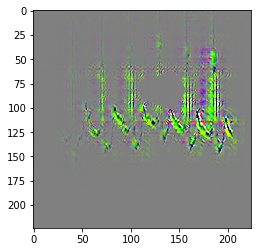

In [45]:
plt.imshow(cam_gb)
plt.show()